In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import Reconstruction_dataset as dt
import model_4_o as mdo
import model_ResUGAN as md
import numpy as np
import copy
import os, glob
from pytorch_ssim import ssim
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, utils, models
import csvgenerator as csvg
from torch.autograd import Variable
import pandas as pd
import math
import torchvision
import time
from skimage import io, transform, img_as_float
import copy
import csv
import cv2

In [6]:
# print gpu
torch.cuda.set_device(0)
currentDevice = torch.cuda.current_device()
print("Current GPU: " + str(currentDevice))
print(str(torch.cuda.device_count()))
print(str(torch.cuda.get_device_capability(currentDevice)))
print(torch.__version__)

USE_GPU = 0
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = "cpu"
print(device)

Current GPU: 0
2
(6, 1)
1.0.0
cpu


In [7]:
cwd = os.getcwd()
path = os.path.join(cwd, 'Saved model', 'GAN_output', 'trained_generator.pth')

# path = os.path.join(cwd, 'Best model', 'encoderresinfo_0414.pth')
state_dict = torch.load(path, map_location=torch.device('cuda:0'))
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
# # model = md.Net()
model = md.GeneratorUNet()
# model.load_state_dict(new_state_dict)
model.load_state_dict(new_state_dict)
model.eval()
model.to(device)

GeneratorUNet(
  (down1): UNetDown(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
      (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): LeakyReLU(negative_slope=0.1)
    )
    (side): Sequential(
      (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2), bias=False)
    )
  )
  (skip1): SkipBlock(
    (skip): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
      (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.1)
    )
  )
  (down2): UNetDown(
    (model): Sequential(
 

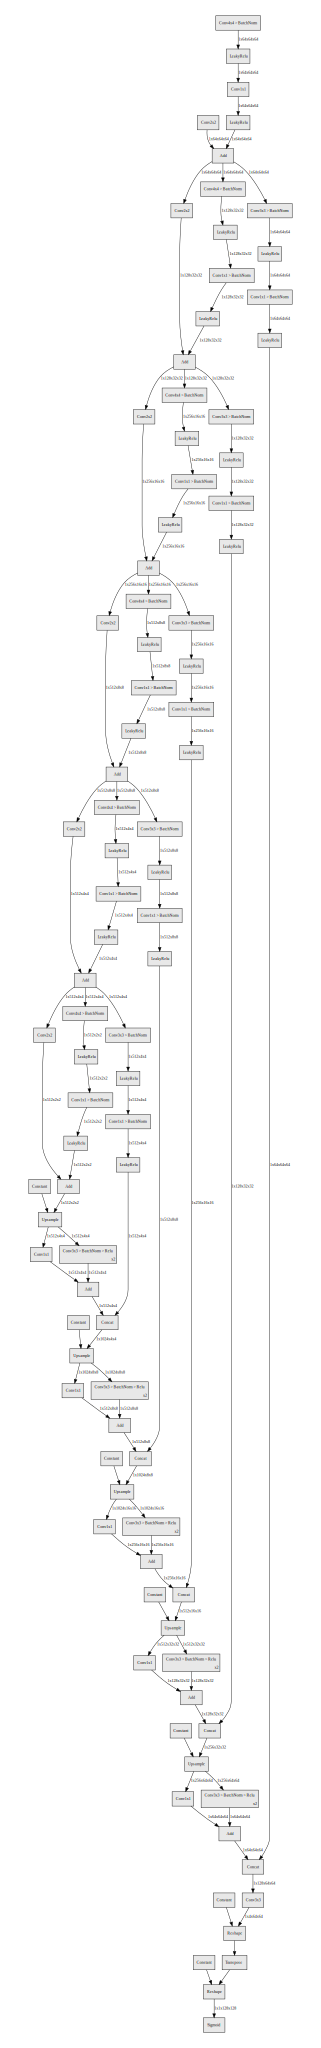

In [8]:
from torchsummary import summary
import hiddenlayer as hl

#summary(model, (3, 128, 128))
hl.build_graph(model, torch.zeros([1, 3, 128, 128]))


In [ ]:
cwd = os.getcwd()
path = os.path.join(cwd, 'Best model', 'ournetwork.pth')

# path = os.path.join(cwd, 'Best model', 'encoderresinfo_0414.pth')
state_dict = torch.load(path, map_location=torch.device('cuda:0'))
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
model1 = mdo.Net()
# model1 = md.GeneratorUNet()
model1.load_state_dict(new_state_dict)
model1.eval()
model1.to(device)

In [ ]:
csv_file='J:\\Manuscripts\\Drifka Oncotarget\\Teresa TMA for prognostic study\\H&E analysis\\ImageScope cropped H&E cores\\image_list.csv'
out_dir= 'J:\\Manuscripts\\Drifka Oncotarget\\Teresa TMA for prognostic study\\H&E analysis\\ImageScope cropped H&E cores\Synthesized_SHG\\'
patch_size=128
stride=96
resize_factor=1
minibatch_size=32
window_size=int(patch_size/stride)

transformed_dataset = dt.HE_SHG_Dataset(csv_file,
                                               transform=dt.Compose([                                              
                                               dt.Normalize(),
                                               dt.ToTensor()
                                           ]))
# TODO: change the normalization parameters

files_list = pd.read_csv(csv_file)

for file_ind in range(len(transformed_dataset)):
    
    sample = transformed_dataset[file_ind].permute((1,2,0)).numpy()
    resized_sample = cv2.resize(sample, (sample.shape[0]*resize_factor,sample.shape[1]*resize_factor))

    img_file_name = files_list.iloc[file_ind, 0]
    img_name = img_file_name.split('\\')[-1]
   

    image = resized_sample
    y_size = image.shape[0]
    x_size = image.shape[1]
    padded_image= cv2.copyMakeBorder(image,stride,stride,stride,stride,cv2.BORDER_REFLECT)

    y_patch_num = int(math.floor((image.shape[0])/stride))
    x_patch_num = int(math.floor((image.shape[1])/stride))
    out_mat=np.zeros((y_patch_num, x_patch_num, patch_size*patch_size))
    minibatch = np.zeros((int(window_size*window_size),patch_size,patch_size,3))
            
            
    for i in range(y_patch_num):
        for j in range(x_patch_num):

            out_mat[i, j, 0]=i*stride
            out_mat[i, j, 1]=j*stride
            k=0      
            for y_window in range(window_size):
                for x_window in range(window_size):

                    row_start = int(out_mat[i, j, 0] + y_window * stride)
                    col_start = int(out_mat[i, j, 1] + x_window * stride)
                    minibatch[k,:,:,:]=padded_image[row_start : row_start + patch_size, col_start : col_start + patch_size, :]
                    k=k+1


            net_input = torch.tensor(minibatch.transpose(0,3,1,2),dtype=torch.float, 
                                     device=torch.device('cuda:0'))
            outputs_window = model_ft(net_input)
            output_patch = outputs_window.data.cpu().numpy()
            tile_output = np.mean(output_patch, axis=0)
            out_mat[i, j, 2:] = tile_output
            

    mask = np.zeros(((y_patch_num+1)*stride,(x_patch_num+1)*stride,3))
    normalized_output = out_mat[:, :, 2:].clip(min=0)
    normalized_output = normalized_output / np.max(normalized_output)
    for i in range(y_patch_num):
        for j in range(x_patch_num):
            
            G1_factor = normalized_output[i,j,0]
            hsv_G1 = np.uint8([[[120,255,math.floor(255*G1_factor)]]])# Blue for grade one
            G1_rgb = cv2.cvtColor(hsv_G1, cv2.COLOR_HSV2RGB )
            G2_factor = normalized_output[i,j,1]
            hsv_G2 = np.uint8([[[60,255,math.floor(255*G2_factor)]]])#Purple for grade two
            G2_rgb = cv2.cvtColor(hsv_G2, cv2.COLOR_HSV2RGB )
            G3_factor = normalized_output[i,j,2]
            hsv_G3 = np.uint8([[[0,255,math.floor(255*G3_factor)]]])#Red for grade three
            G3_rgb = cv2.cvtColor(hsv_G3, cv2.COLOR_HSV2RGB )
            N_factor = normalized_output[i,j,3]
            hsv_N = np.uint8([[[60,255,math.floor(255*N_factor)]]]) #Green for normal
            N_rgb = cv2.cvtColor(hsv_N, cv2.COLOR_HSV2RGB )

            color_average = ( G1_rgb + G2_rgb + G3_rgb + N_rgb)/4
            tile = color_average
            row_start = int(out_mat[i, j, 0])
            col_start = int(out_mat[i, j, 1])
            
            mask[row_start : row_start + stride, col_start : col_start + stride, :] = tile.repeat(stride, axis=0).repeat(stride, axis=1)
            
    mask_image = np.uint8(mask[ :image.shape[0], : image.shape[1], :])
    mask_name = [out_dir , 'mask_for_' , img_name, '.tif']
    mask_name=''.join(mask_name)

    cv2.imwrite(mask_name, mask_image)

    
    print(mask_name)

In [ ]:
 out_mat=np.random.random((3, 3, 2))
print(out_mat,out_mat.shape)

In [ ]:
out_mat[1,2,0]

In [ ]:
csv_file='J:\\Manuscripts\\Drifka Oncotarget\\Teresa TMA for prognostic study\\H&E analysis\\ImageScope cropped H&E cores\\image_list.csv'
out_dir= 'J:\\Manuscripts\\Drifka Oncotarget\\Teresa TMA for prognostic study\\H&E analysis\\ImageScope cropped H&E cores\Synthesized_SHG\\'
patch_size=128
stride=96
resize_factor=1
minibatch_size=32
window_size=int(patch_size/stride)

transformed_dataset = dt.HE_SHG_Dataset(csv_file,
                                               transform=dt.Compose([                                              
                                               dt.Normalize(),
                                               dt.ToTensor()
                                           ]))
# TODO: change the normalization parameters

files_list = pd.read_csv(csv_file)

for file_ind in range(len(transformed_dataset)):
    
    sample = transformed_dataset[file_ind].permute((1,2,0)).numpy()
    resized_sample = cv2.resize(sample, (sample.shape[0]*resize_factor,sample.shape[1]*resize_factor))

    img_file_name = files_list.iloc[file_ind, 0]
    img_name = img_file_name.split('\\')[-1]
   

    image = resized_sample
    y_size = image.shape[0]
    x_size = image.shape[1]
    padded_image= cv2.copyMakeBorder(image,stride,stride,stride,stride,cv2.BORDER_REFLECT)

    y_patch_num = int(math.floor((image.shape[0])/stride))
    x_patch_num = int(math.floor((image.shape[1])/stride))
    out_mat=np.zeros((y_patch_num, x_patch_num, patch_size*patch_size))
    minibatch = np.zeros((int(window_size*window_size),patch_size,patch_size,3))
            
        
    for i in range(y_patch_num):
        for j in range(x_patch_num):

            out_mat[i, j, 0]=i*stride
            out_mat[i, j, 1]=j*stride
            k=0      
            for y_window in range(window_size):
                for x_window in range(window_size):

                    row_start = int(out_mat[i, j, 0] + y_window * stride)
                    col_start = int(out_mat[i, j, 1] + x_window * stride)
                    minibatch[k,:,:,:]=padded_image[row_start : row_start + patch_size, col_start : col_start + patch_size, :]
                    k=k+1


            net_input = torch.tensor(minibatch.transpose(0,3,1,2),dtype=torch.float, 
                                     device=torch.device('cuda:0'))
            outputs_window = model_ft(net_input)
            output_patch = outputs_window.data.cpu().numpy()
            tile_output = np.mean(output_patch, axis=0)
            out_mat[i, j, 2:] = tile_output
            if file_ind == 1:
                break
            


In [ ]:
print(transformed_dataset[file_ind].shape)

In [ ]:
unfold = nn.Unfold(kernel_size=(2, 3))
input = torch.randn(1,3, 3, 3)
output = unfold(input)
print(input)

In [ ]:
print(output,output.shape)